# Проект по semantic и instance сегментации

## Dataset

Сперва посмотрим на наши данные:

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2 as cv
from utils.utils import parse_paths


SPLIT_PATH = Path('split.csv').resolve()

train_path, val_path, test_path = parse_paths(split_path=SPLIT_PATH)
img = cv.cvtColor(cv.imread(train_path[0][0]), cv.COLOR_BGR2RGB)
sem = cv.cvtColor(cv.imread(train_path[0][1]), cv.COLOR_BGR2RGB)
inst = cv.cvtColor(cv.imread(train_path[0][2]), cv.COLOR_BGR2RGB)


fig, axes = plt.subplots(ncols=3, figsize=(14, 14))
axes[0].imshow(img)
axes[1].imshow(sem)
axes[2].imshow(inst)

[ WARN:0@0.020] global loadsave.cpp:248 findDecoder imread_('data/A1/plant001_rgb.png'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [2]:
from utils.dataset import SemanticSegmentationDataset


resolution = (512,512)

train_dataset = SemanticSegmentationDataset(train_path, resolution)
val_dataset = SemanticSegmentationDataset(val_path, resolution)
test_dataset = SemanticSegmentationDataset(test_path, resolution)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 712
Val size: 35
Test size: 63


In [3]:
from torch.utils.data import DataLoader


batch_size = 2

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

## Semantic segmentation

In [4]:
import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
from model.model import ResUNet
from utils.utils import trainable_parameters

model = ResUNet()
trainable_parameters(model)

Params: 5.3M


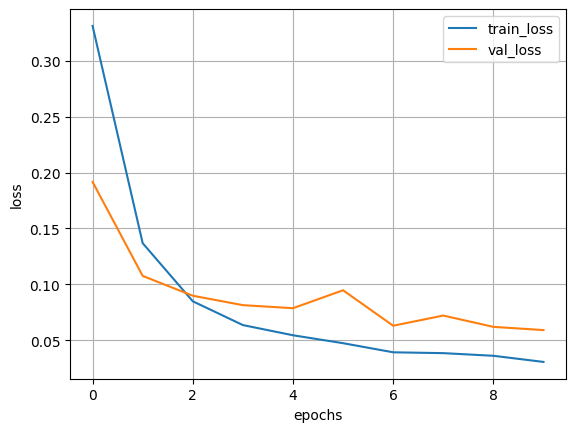

In [6]:
from utils.training import train
import torch.nn as nn


model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
critereon = nn.BCEWithLogitsLoss()

train(model, critereon, optimizer, epochs=10, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, device=device, save=True, path='model/solution.pt');


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predict')

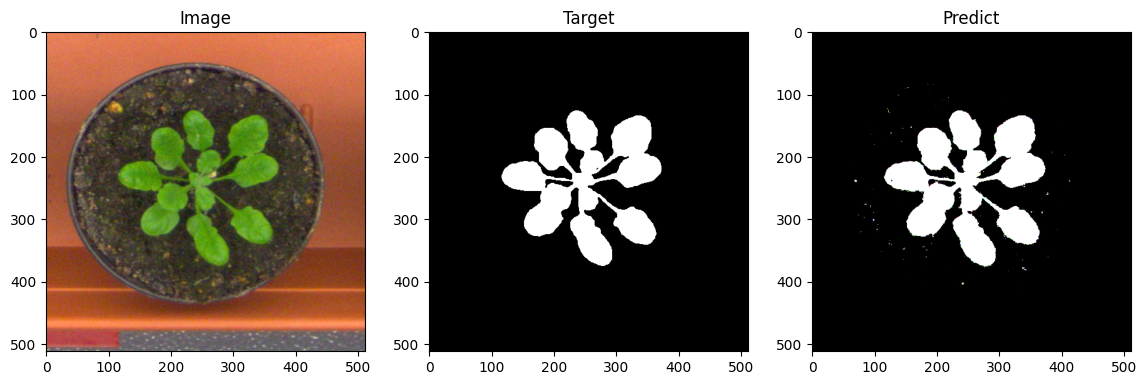

In [7]:
X, y = next(iter(valid_dataloader))
pred = model(X[0].unsqueeze(0).to(device)).cpu().detach().squeeze(0)

fig, axes = plt.subplots(ncols=3, figsize=(14, 14))
axes[0].imshow(X[0].permute(1, 2, 0))
axes[0].set_title('Image')
axes[1].imshow(y[0].permute(1, 2, 0))
axes[1].set_title('Target')
axes[2].imshow(pred.permute(1, 2, 0))
axes[2].set_title('Predict')

## Metrics

In [8]:
import utils.metrics as metrics
import importlib

importlib.reload(metrics)

dice = metrics.count_metric(model, test_dataloader, metrics.dice_coef, device)
mse = metrics.count_metric(model, test_dataloader, nn.functional.mse_loss, device)

In [9]:
print("Results for U-Net with ResNet blocks: ")
print("DICE coef: ", dice)
print("MSE loss: ", mse)

Results for U-Net with ResNet blocks: 
DICE coef:  0.2596415877342224
MSE loss:  0.013569262810051441


## Result

In [10]:
import utils.utils as utils
import importlib

importlib.reload(utils)

utils.test_predicts(model, test_dataset, 'data/test_results/', device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i